In [1]:
import pandas as pd

In [2]:
df_ncc = pd.read_csv("./ncc.binetflow")
df_ncc=df_ncc[~df_ncc['Label'].str.contains("Background", case=False, na=False)]
df_ncc = df_ncc.sample(25000)
df_iot = pd.read_csv("./iot23.csv").sample(25000)
df_ctu = pd.read_csv("./ctu.csv").sample(25000)
df_ctu=df_ctu[~df_ctu['Label'].str.contains("Background", case=False, na=False)]
df_ctu = df_ctu.sample(25000)

C:\Users\tejas\AppData\Local\Temp\ipykernel_2588\157375421.py:1: DtypeWarning: Columns (1,9,10,11,12,13,15,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df_ncc = pd.read_csv("./ncc.binetflow")
C:\Users\tejas\AppData\Local\Temp\ipykernel_2588\157375421.py:4: DtypeWarning: Columns (9,10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df_iot = pd.read_csv("./iot23.csv").sample(25000)
C:\Users\tejas\AppData\Local\Temp\ipykernel_2588\157375421.py:5: DtypeWarning: Columns (5,8,18) have mixed types. Specify dtype option on import or set low_memory=False.
  df_ctu = pd.read_csv("./ctu.csv").sample(25000)


In [3]:
df_iot['ActivityLabel'] = df_iot['label'].apply(lambda x: 0 if x == 'Benign' else 1)
df_iot = df_iot.drop(columns=['label'])
df_ctu['ActivityLabel'] = df_ctu['BOTNET'].apply(lambda x: 0 if x == 0 else 1)
df_ctu = df_ctu.drop(columns=['BOTNET'])

In [4]:
import pandas as pd
import numpy as np
import networkx as nx
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE, SelectKBest, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from time import time

In [5]:
def calculate_additional_graph_metrics(G):
    # Calculate in-degree and out-degree
    in_degree = dict(G.in_degree())
    out_degree = dict(G.out_degree())

    # Calculate eigenvector centrality
    eigenvector_centrality = nx.eigenvector_centrality_numpy(G)

    # Calculate betweenness centrality
    betweenness_centrality = nx.betweenness_centrality(G)

    return in_degree, out_degree, eigenvector_centrality, betweenness_centrality


def convert_categorical_to_numeric(df):
    le = LabelEncoder()
    for column in df.columns:
        if df[column].dtype == 'object' or df[column].dtype.name == 'category':
            df[column] = le.fit_transform(df[column])
    return df

def convert_categorical_to_numeric(df):
    le = LabelEncoder()
    encoding_maps = {}
    for column in df.columns:
        if column == 'SrcAddr' or column == 'DstAddr':
            if df[column].dtype == 'object' or df[column].dtype.name == 'category':
                df[column] = le.fit_transform(df[column])
                encoding_maps[column] = dict(zip(le.transform(le.classes_), le.classes_))
        else:
            if df[column].dtype == 'object' or df[column].dtype.name == 'category':
                df[column] = df[column].astype(str)
                df[column] = le.fit_transform(df[column])
    return df, encoding_maps

In [6]:
from sklearn.preprocessing import MinMaxScaler

def feature_selection_vif(dataset, srcLabel, dstLabel, alpha=0.005, vif_threshold=20):
    # Load and clean the dataset
    df = dataset
    df = df.drop_duplicates()
    df = df.dropna()

    df['ActivityLabel'] = df['ActivityLabel'].apply(lambda x: 0 if x == 0 else 1)

    # Convert non-numeric features to numeric
    df, maps = convert_categorical_to_numeric(df)

    # Create the graph from IPs
    ips = df[[srcLabel, dstLabel]]
    G = nx.DiGraph()
    for _, row in ips.iterrows():
        G.add_edge(row[srcLabel], row[dstLabel])

    # Calculate centrality metrics
    degree_centrality = nx.degree_centrality(G)
    closeness_centrality = nx.closeness_centrality(G)
    betweenness_centrality = nx.betweenness_centrality(G)

    def refined_normalize(metric):
        values = np.array(list(metric.values()))
        if len(values) == 0 or values.max() == values.min():
            return dict(zip(metric.keys(), values))
        percentiles = np.percentile(values, np.linspace(0, 100, 101))
        normalized_values = np.interp(values, percentiles, np.linspace(0, 1, 101))
        return dict(zip(metric.keys(), normalized_values))

    degree_centrality_norm = refined_normalize(degree_centrality)
    closeness_centrality_norm = refined_normalize(closeness_centrality)
    betweenness_centrality_norm = refined_normalize(betweenness_centrality)

    # Compute Composite Node Importance (CNI)
    cni_scores = {}
    for node in G.nodes():
        cni_scores[node] = (degree_centrality_norm.get(node, 0) +
                            closeness_centrality_norm.get(node, 0) +
                            betweenness_centrality_norm.get(node, 0)) / 3

    # Calculate additional graph metrics
    in_degree, out_degree, eigenvector_centrality, betweenness_centrality = calculate_additional_graph_metrics(G)

    # Add CNI scores and other metrics to the dataset
    dataset_with_metrics = df.copy()
    dataset_with_metrics['orig_h_CNI'] = dataset_with_metrics[srcLabel].map(cni_scores)
    dataset_with_metrics['resp_h_CNI'] = dataset_with_metrics[dstLabel].map(cni_scores)
    dataset_with_metrics['average_CNI'] = dataset_with_metrics[['orig_h_CNI', 'resp_h_CNI']].mean(axis=1)

    ip_cni_map = {ip: cni_scores[ip] for ip in cni_scores if ip in dataset_with_metrics[srcLabel].unique() or ip in dataset_with_metrics[dstLabel].unique()}
    df_final = dataset_with_metrics

    # Normalize the features
    scaler = MinMaxScaler()
    df_normalized = pd.DataFrame(scaler.fit_transform(df_final), columns=df_final.columns)

    # Calculate traditional VIF
    def calculate_vif(df):
        df = df.drop(["orig_h_CNI", "resp_h_CNI"], axis=1)
        X = df.values
        vif_scores = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
        vif_data = pd.DataFrame({'Feature': df.columns, 'Traditional_VIF': vif_scores})
        return vif_data

    
    start_time_1 = time()
    vif_results = calculate_vif(df_normalized)
    vif_time = time() - start_time_1
    vif_scores = vif_results

    # Iterative VIF-based feature selection
    features_to_remove = []
    high_vif_features = vif_results[vif_results['Traditional_VIF'] > vif_threshold]['Feature'].tolist()
    while high_vif_features:
        feature_to_remove = high_vif_features[0]
        features_to_remove.append(feature_to_remove)
        vif_results = vif_results[vif_results['Feature'] != feature_to_remove]
        remaining_features = vif_results['Feature'].tolist()
        X_subset = df_normalized[remaining_features]
        vif_results['Traditional_VIF'] = [variance_inflation_factor(X_subset.values, i) for i in range(X_subset.shape[1])]
        high_vif_features = vif_results[vif_results['Traditional_VIF'] > vif_threshold]['Feature'].tolist()

    # Calculate Modified VIF
    def calculate_modified_vif(X, alpha):
        X = X.drop(["orig_h_CNI", "resp_h_CNI"], axis=1)
        
        features = X.columns
        mvif_data = []
        for feature in features:
            predictors = [feat for feat in features if feat != feature]
            model = LinearRegression().fit(X[predictors], X[feature])
            r_squared = model.score(X[predictors], X[feature])
            average_cni_mean = dataset_with_metrics['average_CNI'].mean()
            # Normalizing the adjustment term
            normalized_adjustment = (r_squared + alpha * average_cni_mean) / (1 + alpha * average_cni_mean)
        
        # Ensure the value inside the division is positive
            if normalized_adjustment >= 1.0:
                normalized_adjustment = 1.0 - 1e-6  # Adjust to avoid negative or zero denominator

            modified_vif = 1 / (1 - normalized_adjustment)
            mvif_data.append({'Feature': feature, 'Modified_VIF': modified_vif})
        
        return pd.DataFrame(mvif_data)

    X = df_normalized
    start_time_1 = time()
    mvif_results = calculate_modified_vif(X, alpha)
    mvif_time = time() - start_time_1

    final_vif_results = pd.merge(vif_scores, mvif_results, on='Feature')
    selected_features = mvif_results[mvif_results['Modified_VIF'] < vif_threshold]['Feature'].tolist()

    return df_final, final_vif_results,mvif_time,vif_time


In [7]:
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
import numpy as np

def apply_pca_rfe_and_compare(df, final_vif_results, label_col='ActivityLabel', vif_threshold=10):
    selected_features_vif = final_vif_results[final_vif_results['Traditional_VIF'] < vif_threshold]['Feature'].tolist()
    selected_features_mvif = final_vif_results[final_vif_results['Modified_VIF'] < vif_threshold]['Feature'].tolist()
    X_vif = df[selected_features_vif]
    X_mvif = df[selected_features_mvif]
    y = df[label_col]

    # Apply PCA
    start_time = time()
    pca = PCA(n_components=0.95)  # Retain 95% of variance
    X_pca = pca.fit_transform(df.drop(columns=[label_col]))
    pca_time = time() - start_time

    # Get PCA loadings and select top features
    pca_loadings = pd.DataFrame(pca.components_.T, columns=[f'PC{i+1}' for i in range(pca.n_components_)], index=df.drop(columns=[label_col]).columns)
    pca_selected_features = pca_loadings.abs().mean(axis=1).nlargest(10).index.tolist()  # Select top 10 features

    # Apply RFE
    start_time = time()
    model = LogisticRegression(solver='liblinear')
    rfe = RFE(model, n_features_to_select=10)
    rfe.fit(df.drop(columns=[label_col]), y)
    rfe_selected_features = df.drop(columns=[label_col]).columns[rfe.support_].tolist()
    rfe_time = time() - start_time

    # Compile the results
    result = {
        'VIF': selected_features_vif,
        'CNI-VIF': selected_features_mvif,
        'PCA': pca_selected_features,
        'RFE': rfe_selected_features
    }

    # Return results and times
    return result, pca_time, rfe_time

In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from time import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, MaxPooling1D
from keras.utils import to_categorical

def create_ffnn(input_shape):
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(input_shape,)))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def create_cnn(input_shape):
    model = Sequential()
    model.add(Conv1D(32, 3, activation='relu', input_shape=input_shape))
    
    # Check if the input shape after the first Conv1D layer allows pooling
    if input_shape[0] >= 4:
        model.add(MaxPooling1D(2))
        
        # Check the new shape after pooling
        new_shape = input_shape[0] // 2
        
        # Check if the shape allows another Conv1D layer and pooling
        if new_shape >= 5:  # Because kernel size is 3, we need at least 3+2
            model.add(Conv1D(64, 3, activation='relu'))
            
            # Check if the new shape allows another pooling
            if new_shape - 2 >= 2:
                model.add(MaxPooling1D(2))
    
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


def evaluate_models(selection_result, df, label_col='ActivityLabel'):
    models = {
        'Logistic Regression': LogisticRegression(solver='liblinear'),
        'Random Forest': RandomForestClassifier(),
        'SVM': SVC(probability=True),
        'Ensemble (Voting)': VotingClassifier(
            estimators=[
                ('lr', LogisticRegression(solver='liblinear')),
                ('rf', RandomForestClassifier()),
                ('svm', SVC(probability=True))
            ], voting='soft'
        )
    }
    
    results = {technique: {} for technique in selection_result.keys()}
    
    for technique, features in selection_result.items():
        X = df[features]
        y = df[label_col]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
        
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        
        for model_name, model in models.items():
            start_time = time()
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            computation_time = time() - start_time
            
            results[technique][model_name] = {
                'Accuracy': accuracy,
                'Precision': precision,
                'Recall': recall,
                'F1-Score': f1,
                'Computation Time': computation_time
            }
        
        start_time = time()
        ffnn = create_ffnn(X_train.shape[1])
        ffnn.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)
        y_pred_ffnn = (ffnn.predict(X_test) > 0.5).astype(int).flatten()
        accuracy_ffnn = accuracy_score(y_test, y_pred_ffnn)
        precision_ffnn = precision_score(y_test, y_pred_ffnn)
        recall_ffnn = recall_score(y_test, y_pred_ffnn)
        f1_ffnn = f1_score(y_test, y_pred_ffnn)
        computation_time_ffnn = time() - start_time
        
        results[technique]['FFNN'] = {
            'Accuracy': accuracy_ffnn,
            'Precision': precision_ffnn,
            'Recall': recall_ffnn,
            'F1-Score': f1_ffnn,
            'Computation Time': computation_time_ffnn
        }
        
        start_time = time()
        X_train_cnn = np.expand_dims(X_train, axis=2)
        X_test_cnn = np.expand_dims(X_test, axis=2)
        input_shape = (X_train_cnn.shape[1], X_train_cnn.shape[2])
        cnn = create_cnn(input_shape)
        cnn.fit(X_train_cnn, y_train, epochs=10, batch_size=32, verbose=0)
        y_pred_cnn = (cnn.predict(X_test_cnn) > 0.5).astype(int).flatten()
        accuracy_cnn = accuracy_score(y_test, y_pred_cnn)
        precision_cnn = precision_score(y_test, y_pred_cnn)
        recall_cnn = recall_score(y_test, y_pred_cnn)
        f1_cnn = f1_score(y_test, y_pred_cnn)
        computation_time_cnn = time() - start_time
        
        results[technique]['CNN'] = {
            'Accuracy': accuracy_cnn,
            'Precision': precision_cnn,
            'Recall': recall_cnn,
            'F1-Score': f1_cnn,
            'Computation Time': computation_time_cnn
        }
    
    print(results)
    return results


import matplotlib.pyplot as plt
import numpy as np

import matplotlib.pyplot as plt
import numpy as np

def plot_accuracies_by_model(results,dataset_name):
    # Extract techniques and models
    techniques = list(results.keys())
    models = list(next(iter(results.values())).keys())
    # Define a list of colors to use for the plots
    colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'cyan', 'magenta']
    for i, model in enumerate(models):
        accuracies = [results[technique][model]['Accuracy'] for technique in techniques]
        # Plotting line graph for accuracies with a unique color
        plt.figure(figsize=(10, 6))
        plt.plot(techniques, accuracies, marker='o', linestyle='-', color=colors[i % len(colors)], label=model)
        plt.xlabel('Feature Selection Techniques')
        plt.ylabel('Accuracy')
        plt.title(f'Accuracy of {model} Across Feature Selection Techniques for {dataset_name}')
        plt.xticks(rotation=45)
        plt.ylim(0, 1.1)  # Optional: Set y-axis limit to ensure uniformity across all plots
        plt.grid(True)
        plt.show()


def plot_computation_time_for_random_forest(results,dataset_name):
    techniques = list(results.keys())
    computation_times = [results[technique]['Random Forest']['Computation Time'] for technique in techniques]
    
    # Plotting line graph for computation times
    plt.figure(figsize=(10, 6))
    plt.plot(techniques, computation_times, marker='o', linestyle='-', color='orange')
    plt.xlabel('Feature Selection Techniques')
    plt.ylabel('Computation Time (s)')
    plt.title('Computation Time for Random Forest Across Feature Selection Techniques for {dataset_name}')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()


def plot_results(results, title):
    plot_data = []
    for technique, metrics in results.items():
        for model_name, result in metrics.items():
            plot_data.append({
                'Technique': technique,
                'Model': model_name,
                'Accuracy': result['Accuracy'],
                'Precision': result['Precision'],
                'Recall': result['Recall'],
                'F1-Score': result['F1-Score'],
                'Computation Time': result['Computation Time']
            })
    plot_df = pd.DataFrame(plot_data)
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Technique', y='Accuracy', hue='Model', data=plot_df)
    plt.title(f'Model Accuracy by Feature Selection Technique for {title}')
    plt.ylabel('Accuracy')
    plt.xlabel('Feature Selection Technique')
    plt.legend(loc='best')
    plt.show()
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Technique', y='Precision', hue='Model', data=plot_df)
    plt.title(f'Model Precision by Feature Selection Technique for {title}')
    plt.ylabel('Precision')
    plt.xlabel('Feature Selection Technique')
    plt.legend(loc='best')
    plt.show()
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Technique', y='Recall', hue='Model', data=plot_df)
    plt.title(f'Model Recall by Feature Selection Technique for {title}')
    plt.ylabel('Recall')
    plt.xlabel('Feature Selection Technique')
    plt.legend(loc='best')
    plt.show()
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Technique', y='F1-Score', hue='Model', data=plot_df)
    plt.title(f'Model F1-Score by Feature Selection Technique for {title}')
    plt.ylabel('F1-Score')
    plt.xlabel('Feature Selection Technique')
    plt.legend(loc='best')
    plt.show()
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Technique', y='Computation Time', hue='Model', data=plot_df)
    plt.title(f'Model Computation Time by Feature Selection Technique for {title}')
    plt.ylabel('Computation Time (seconds)')
    plt.xlabel('Feature Selection Technique')
    plt.legend(loc='best')
    plt.show()

def extract_data(data):
    result = []
    for feature_selection in data:
        for model, metrics in data[feature_selection].items():
            result.append([
                feature_selection,
                model,
                metrics['Accuracy'],
                metrics['Precision'],
                metrics['Recall'],
                metrics['F1-Score'],
                metrics['Computation Time']
            ])
    return result

def create_table(data):
    df = pd.DataFrame(data, columns=[
        'Feature Selection Technique',
        'Model',
        'Accuracy',
        'Precision',
        'Recall',
        'F1-Score',
        'Computation Time'
    ])
    return df

def plot_times(times,dataset_label):
    algorithms = ['VIF', 'CNI-VIF', 'PCA', 'RFE']
    plt.figure(figsize=(10, 6))
    plt.plot(algorithms, times, marker='o', linestyle='-', color='b')
    plt.xlabel('Algorithm')
    plt.ylabel('Time (seconds)')
    plt.title(f'Algorithm Execution Times for {dataset_label}')
    plt.grid(True)
    plt.show()


In [22]:
def final_output(df,src_label,dst_label,dataset_name):
    df_final,vif_comparison_table,mvif_time,vif_time = feature_selection_vif(df,src_label,dst_label)
    print(vif_comparison_table)

    selection_result,pca_time,rfe_time = apply_pca_rfe_and_compare(df_final, vif_comparison_table)
    print(selection_result)

    plot_times([vif_time,mvif_time,pca_time,rfe_time],dataset_name)
    print(f"PCA:{pca_time} RFE:{rfe_time} CNI-VIF:{mvif_time} VIF:{vif_time}")

    model_results = evaluate_models(selection_result, df_final)
    plot_results(model_results,dataset_name)
    plot_accuracies_by_model(model_results,dataset_name)
    plot_computation_time_for_random_forest(model_results,dataset_name)
    extracted_data = extract_data(model_results)
    table = create_table(extracted_data)
#     print(table)
    return table

C:\Users\tejas\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\regression\linear_model.py:1785: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss
C:\Users\tejas\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\regression\linear_model.py:1785: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss
C:\Users\tejas\AppData\Local\Temp\ipykernel_2588\1112073088.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vif_results['Traditional_VIF'] = [variance_inflation_factor(X_subset.values, i) for i in range(X_subset.shape[1])]
C:\Users\tejas\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\reg

          Feature  Traditional_VIF   Modified_VIF
0       StartTime         3.985168       1.034624
1             Dur         6.337427       1.916038
2           Proto        43.409891       6.591460
3         SrcAddr         6.190973       1.753534
4           Sport         3.258292       2.011600
5             Dir         8.984382       7.010831
6         DstAddr         4.011557       1.499784
7           Dport        20.004148       1.568791
8           State         4.777555       2.054420
9            sTos              NaN  999999.999971
10           dTos              NaN  999999.999971
11        TotPkts         3.759912       1.251516
12       TotBytes         5.266247       1.132818
13       SrcBytes         7.147440       1.321824
14          Label        22.094867       2.891553
15  ActivityLabel        34.453669       8.344233
16     BotnetName        11.230811       3.499257
17       SensorId         3.983459       1.173456
18    average_CNI        10.746826       1.507434


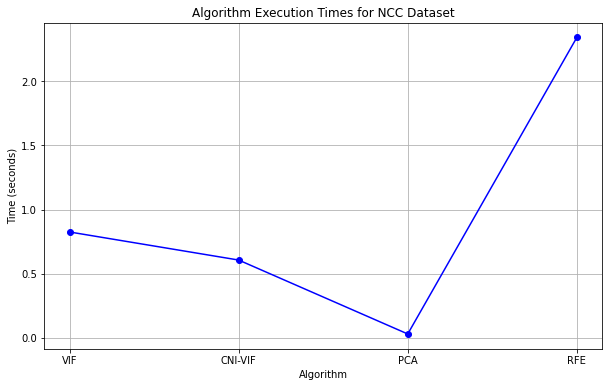

PCA:0.03045511245727539 RFE:2.3417346477508545 CNI-VIF:0.6067001819610596 VIF:0.8254952430725098
202/202 [==============================] - 0s 1ms/step
{'VIF': {'Logistic Regression': {'Accuracy': 0.9541653762774853, 'Precision': 0.967032967032967, 'Recall': 0.9746835443037974, 'F1-Score': 0.9708431836091411, 'Computation Time': 0.03921055793762207}, 'Random Forest': {'Accuracy': 0.9989160730876432, 'Precision': 0.9996041955274094, 'Recall': 0.9990110759493671, 'F1-Score': 0.9993075477297457, 'Computation Time': 1.3950371742248535}, 'SVM': {'Accuracy': 0.9756890678228554, 'Precision': 0.981143193871538, 'Recall': 0.9879351265822784, 'F1-Score': 0.984527446535922, 'Computation Time': 8.302554845809937}, 'Ensemble (Voting)': {'Accuracy': 0.9851347166305358, 'Precision': 0.9874213836477987, 'Recall': 0.9936708860759493, 'F1-Score': 0.9905362776025236, 'Computation Time': 9.14131474494934}, 'FFNN': {'Accuracy': 0.9756890678228554, 'Precision': 0.9851455733808675, 'Recall': 0.98378164556962

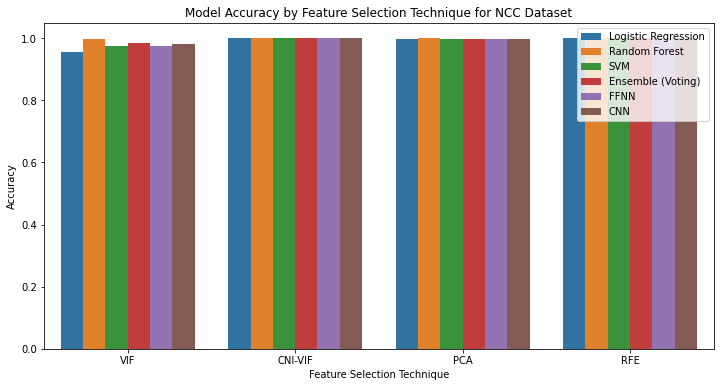

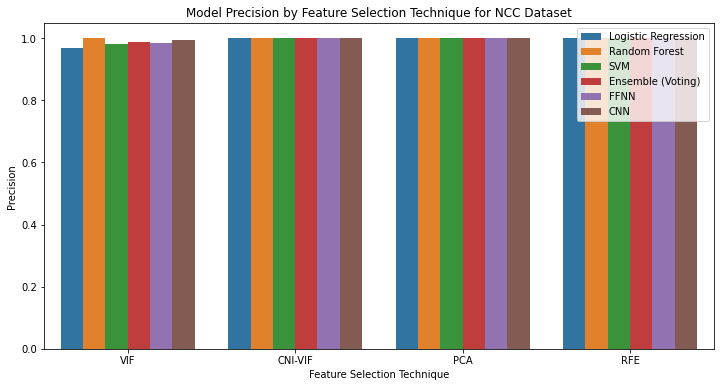

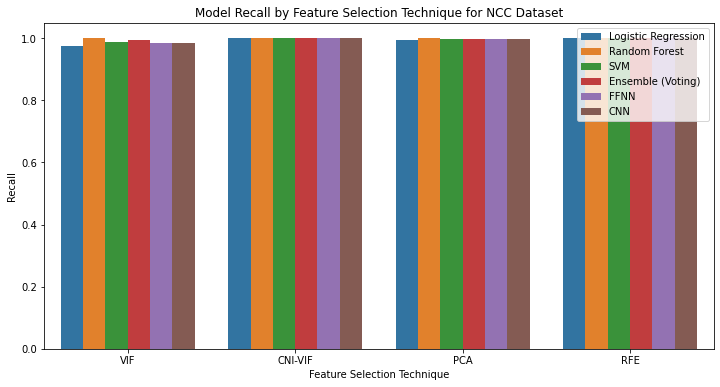

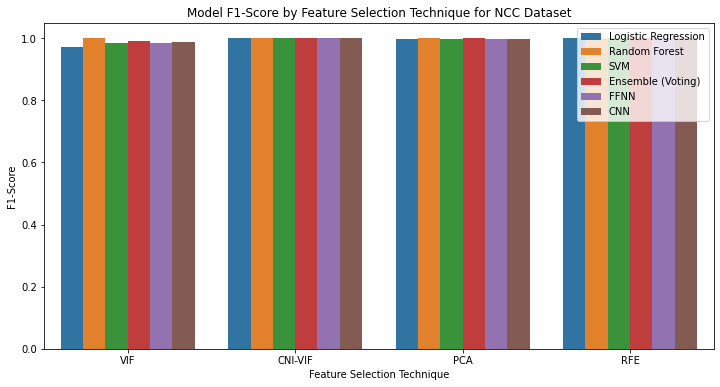

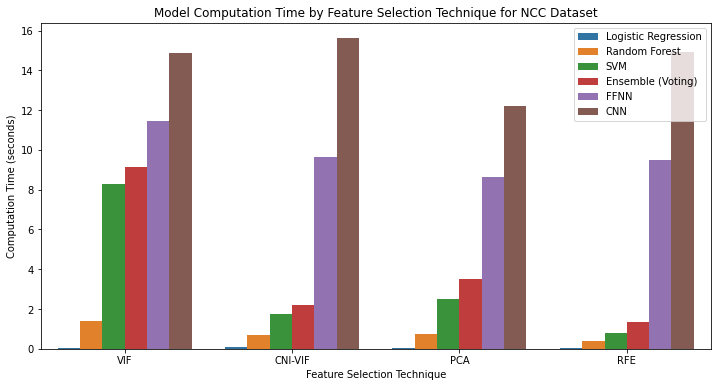

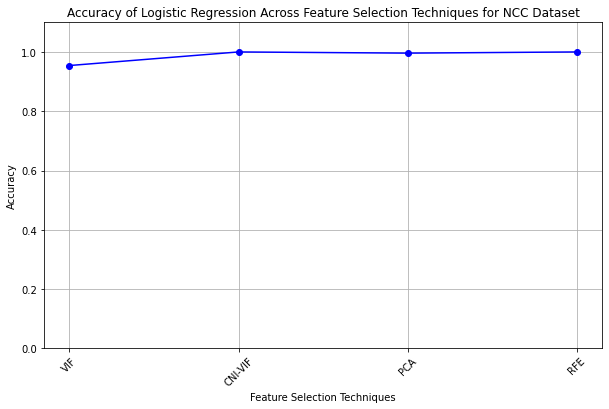

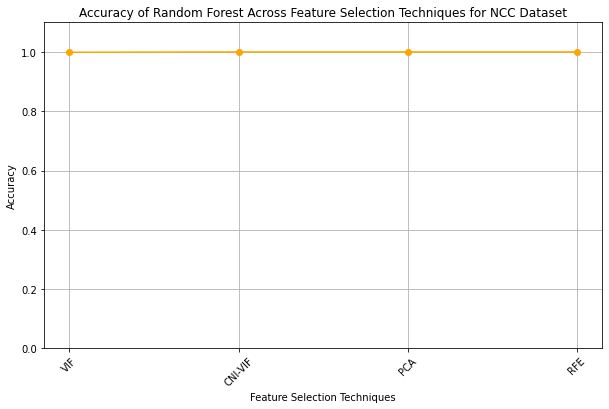

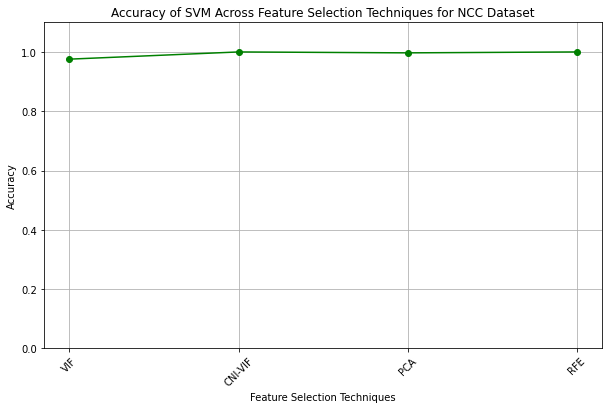

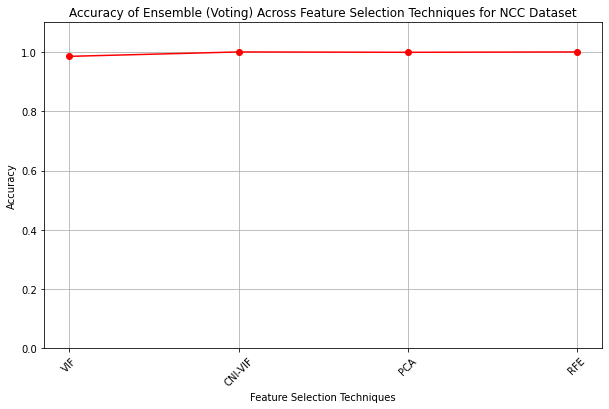

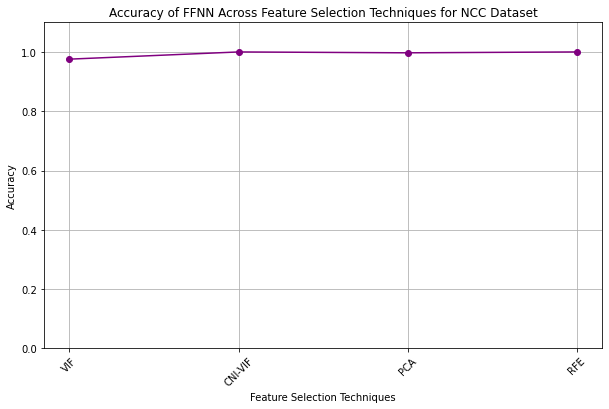

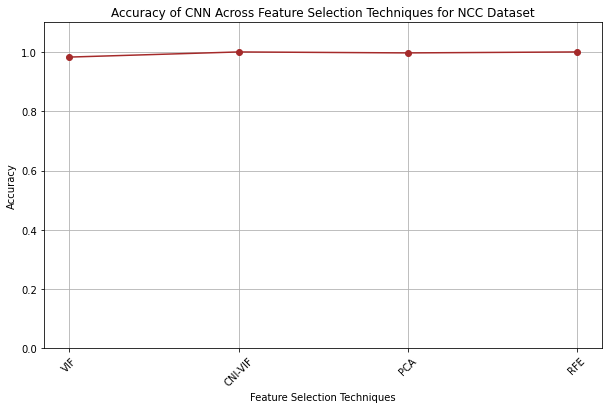

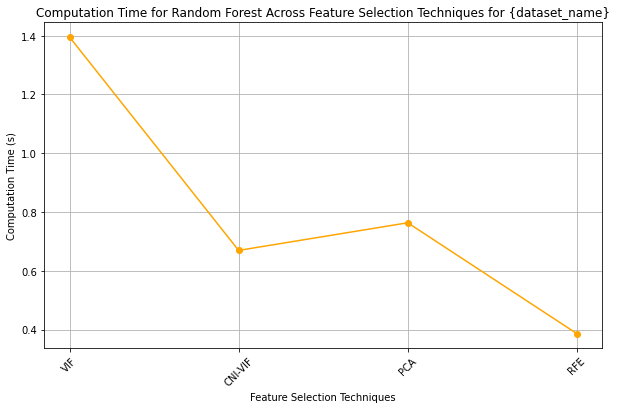

,Feature Selection Technique,Model,Accuracy,Precision,Recall,F1-Score,Computation Time
0,VIF,Logistic Regression,0.954165,0.967033,0.974684,0.970843,0.039211
1,VIF,Random Forest,0.998916,0.999604,0.999011,0.999308,1.395037
2,VIF,SVM,0.975689,0.981143,0.987935,0.984527,8.302555
3,VIF,Ensemble (Voting),0.985135,0.987421,0.993671,0.990536,9.141315
4,VIF,FFNN,0.975689,0.985146,0.983782,0.984463,11.431917
5,VIF,CNN,0.982657,0.994202,0.983584,0.988865,14.879978
6,CNI-VIF,Logistic Regression,1.000000,1.000000,1.000000,1.000000,0.086120
7,CNI-VIF,Random Forest,1.000000,1.000000,1.000000,1.000000,0.669187
8,CNI-VIF,SVM,1.000000,1.000000,1.000000,1.000000,1.724802
9,CNI-VIF,Ensemble (Voting),1.000000,1.000000,1.000000,1.000000,2.218675


In [23]:
table = final_output(df_ncc,"SrcAddr","DstAddr","NCC Dataset")
table

C:\Users\tejas\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\regression\linear_model.py:1785: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss
C:\Users\tejas\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\regression\linear_model.py:1785: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss
C:\Users\tejas\AppData\Local\Temp\ipykernel_2588\1112073088.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vif_results['Traditional_VIF'] = [variance_inflation_factor(X_subset.values, i) for i in range(X_subset.shape[1])]
C:\Users\tejas\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\reg

          Feature  Traditional_VIF   Modified_VIF
0      Unnamed: 0         3.824118       1.034474
1              ts         8.379112       4.819241
2             uid         3.977009       1.004777
3       id.orig_h        83.948897       2.760528
4       id.orig_p         8.015587       1.439055
5       id.resp_h         4.185500       1.076809
6       id.resp_p         2.930318       1.839401
7           proto        47.731199       2.044744
8         service         2.292934       2.288982
9        duration         2.014323       1.470344
10     orig_bytes         4.420473       4.296859
11     resp_bytes         3.166820       3.119776
12     conn_state        40.904446       3.665901
13     local_orig              NaN  999999.999971
14     local_resp              NaN  999999.999971
15   missed_bytes              NaN  999999.999971
16        history        27.160498       3.150114
17      orig_pkts       103.196698     102.126023
18  orig_ip_bytes       105.814029     103.934161


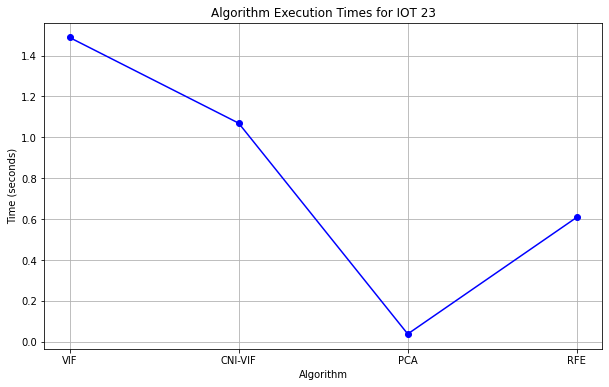

PCA:0.0380244255065918 RFE:0.6088690757751465 CNI-VIF:1.0693933963775635 VIF:1.4885878562927246
235/235 [==============================] - 1s 2ms/step
{'VIF': {'Logistic Regression': {'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'F1-Score': 1.0, 'Computation Time': 0.06255769729614258}, 'Random Forest': {'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'F1-Score': 1.0, 'Computation Time': 1.0521867275238037}, 'SVM': {'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'F1-Score': 1.0, 'Computation Time': 2.1048336029052734}, 'Ensemble (Voting)': {'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'F1-Score': 1.0, 'Computation Time': 3.3192784786224365}, 'FFNN': {'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'F1-Score': 1.0, 'Computation Time': 17.386217832565308}, 'CNN': {'Accuracy': 0.9576, 'Precision': 0.9570068432014281, 'Recall': 0.9955122253172393, 'F1-Score': 0.9758798543689321, 'Computation Time': 26.963749647140503}}, 'CNI-VIF': {'Logistic Regression': {'Accuracy': 1.0, 

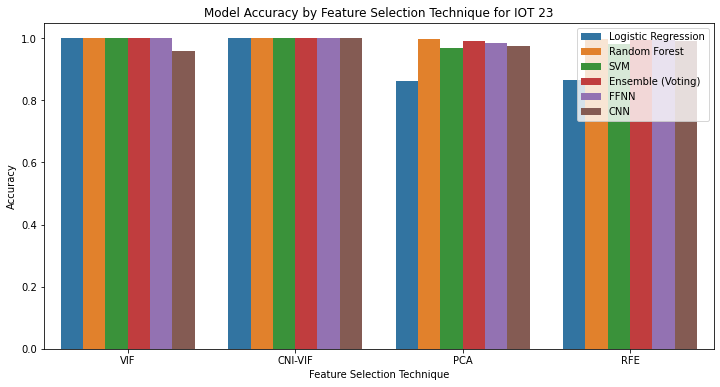

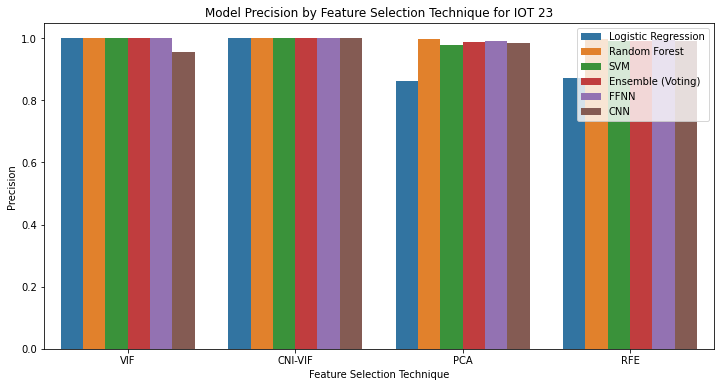

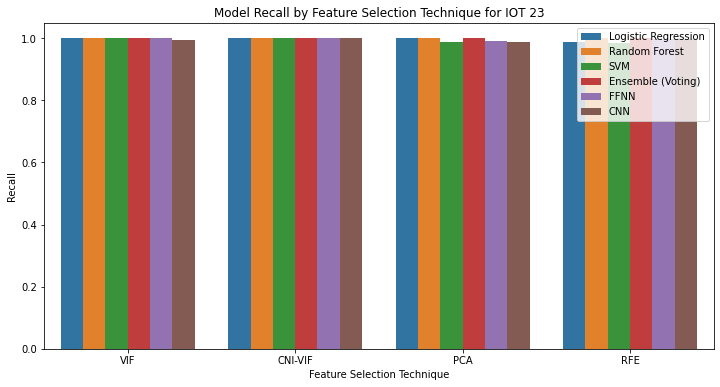

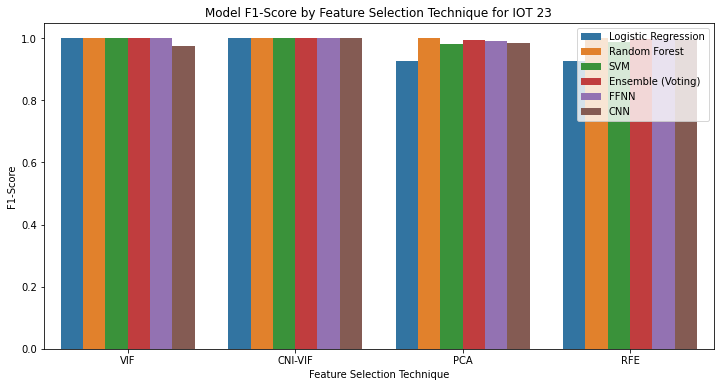

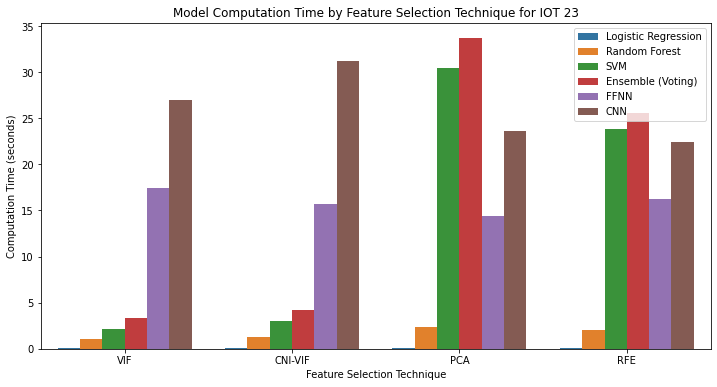

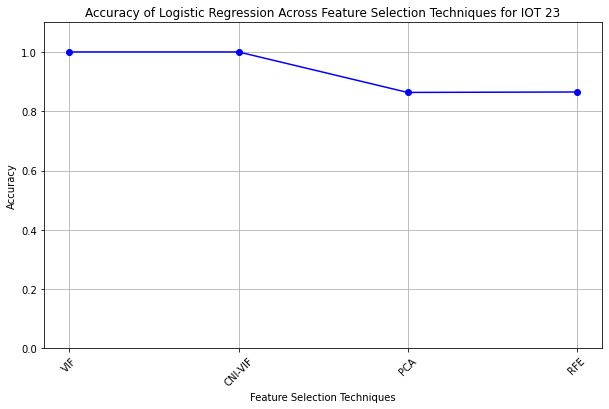

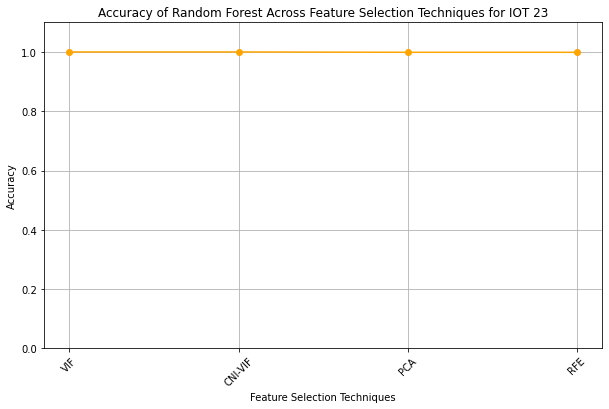

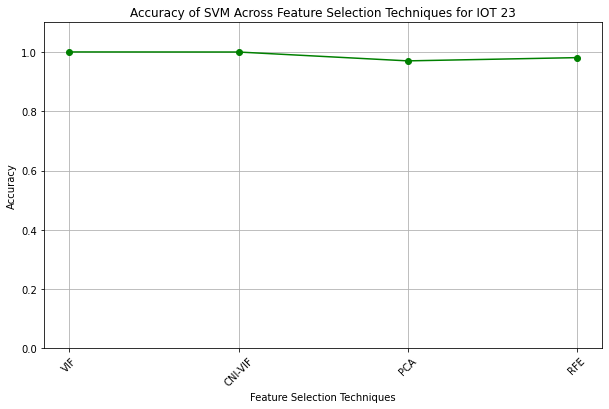

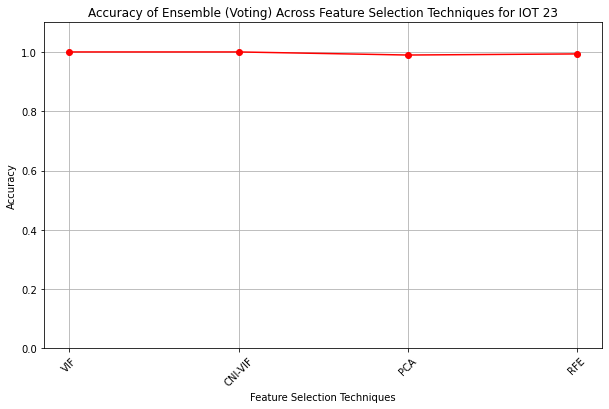

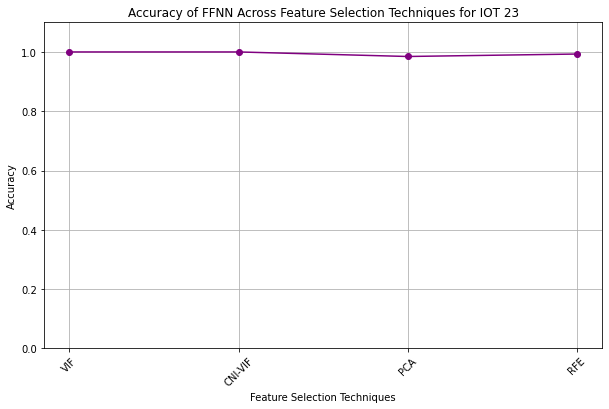

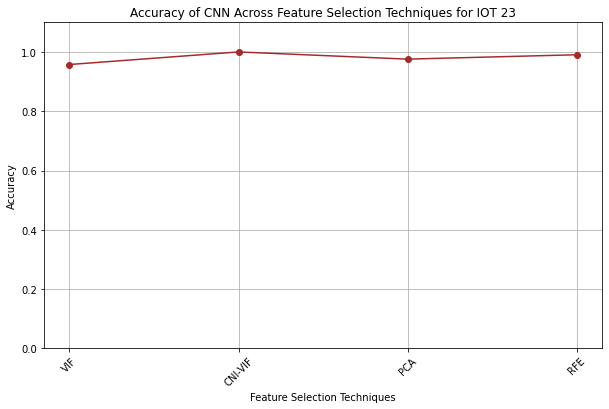

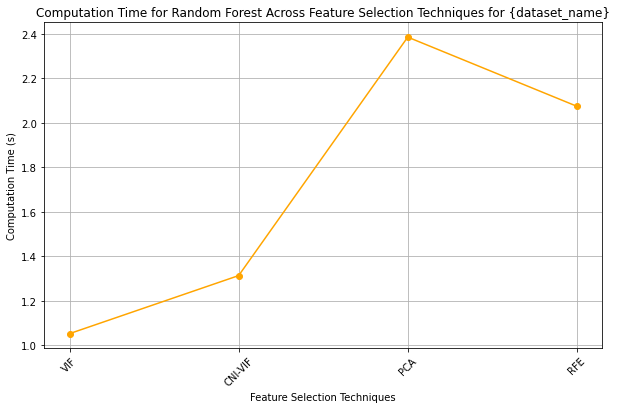

,Feature Selection Technique,Model,Accuracy,Precision,Recall,F1-Score,Computation Time
0,VIF,Logistic Regression,1.000000,1.000000,1.000000,1.000000,0.062558
1,VIF,Random Forest,1.000000,1.000000,1.000000,1.000000,1.052187
2,VIF,SVM,1.000000,1.000000,1.000000,1.000000,2.104834
3,VIF,Ensemble (Voting),1.000000,1.000000,1.000000,1.000000,3.319278
4,VIF,FFNN,1.000000,1.000000,1.000000,1.000000,17.386218
5,VIF,CNN,0.957600,0.957007,0.995512,0.975880,26.963750
6,CNI-VIF,Logistic Regression,1.000000,1.000000,1.000000,1.000000,0.115038
7,CNI-VIF,Random Forest,1.000000,1.000000,1.000000,1.000000,1.313296
8,CNI-VIF,SVM,0.999733,1.000000,0.999690,0.999845,3.020032
9,CNI-VIF,Ensemble (Voting),1.000000,1.000000,1.000000,1.000000,4.159246


In [27]:
table1 = final_output(df_iot,"id.orig_h","id.resp_h","IOT 23")
table1

C:\Users\tejas\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\tejas\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\regression\linear_model.py:1785: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss
C:\Users\tejas\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\regression\linear_model.py:1785: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss
C:\Users\tejas\AppData\Local\Temp\ipykernel_2588\1112073088.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a

          Feature  Traditional_VIF   Modified_VIF
0    Unnamed: 0.1              inf  999999.999971
1      Unnamed: 0              inf  999999.999971
2             Dur         1.156192       1.160374
3           Proto       977.003294     277.779021
4         SrcAddr        10.380774       2.631283
5           Sport         4.662371       2.236158
6             Dir       969.585877     273.503083
7         DstAddr         2.760586       2.321254
8           Dport        27.237177       1.332343
9           State         2.166101       2.080157
10           sTos              NaN  999999.999971
11           dTos              NaN  999999.999971
12        TotPkts        16.324993      16.355717
13       TotBytes        15.514004      15.566258
14       SrcBytes         1.197648       1.201727
15          Label        16.232240       3.021191
16          Train              NaN  999999.999971
17      StartTime         7.927397       1.991505
18  ActivityLabel         3.292189       2.348974


C:\Users\tejas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\tejas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\tejas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\tejas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\tejas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warni

{'VIF': ['Dur', 'Sport', 'DstAddr', 'State', 'SrcBytes', 'StartTime', 'ActivityLabel'], 'CNI-VIF': ['Dur', 'SrcAddr', 'Sport', 'DstAddr', 'Dport', 'State', 'SrcBytes', 'Label', 'StartTime', 'ActivityLabel', 'average_CNI'], 'PCA': ['TotBytes', 'Unnamed: 0.1', 'Unnamed: 0', 'SrcBytes', 'StartTime', 'TotPkts', 'Sport', 'DstAddr', 'Label', 'Dur'], 'RFE': ['Proto', 'SrcAddr', 'Sport', 'Dir', 'DstAddr', 'Dport', 'State', 'TotPkts', 'Label', 'resp_h_CNI']}


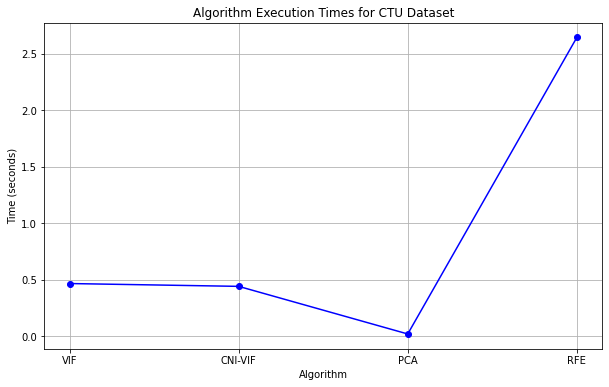

PCA:0.017824411392211914 RFE:2.6443932056427 CNI-VIF:0.4395933151245117 VIF:0.46457529067993164
97/97 [==============================] - 0s 2ms/step
{'VIF': {'Logistic Regression': {'Accuracy': 0.9996747967479674, 'Precision': 0.9990069513406157, 'Recall': 1.0, 'F1-Score': 0.9995032290114257, 'Computation Time': 0.016986370086669922}, 'Random Forest': {'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'F1-Score': 1.0, 'Computation Time': 0.3010995388031006}, 'SVM': {'Accuracy': 0.9996747967479674, 'Precision': 1.0, 'Recall': 0.9990059642147118, 'F1-Score': 0.9995027349577325, 'Computation Time': 0.3924098014831543}, 'Ensemble (Voting)': {'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'F1-Score': 1.0, 'Computation Time': 0.8130791187286377}, 'FFNN': {'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'F1-Score': 1.0, 'Computation Time': 5.812979698181152}, 'CNN': {'Accuracy': 0.7856910569105691, 'Precision': 0.7518142235123367, 'Recall': 0.5149105367793241, 'F1-Score': 0.6112094395280

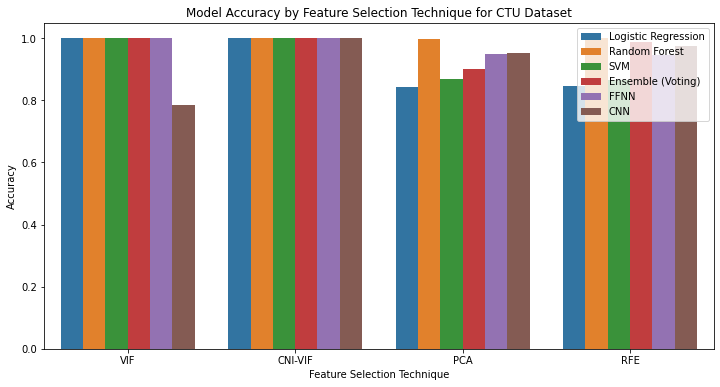

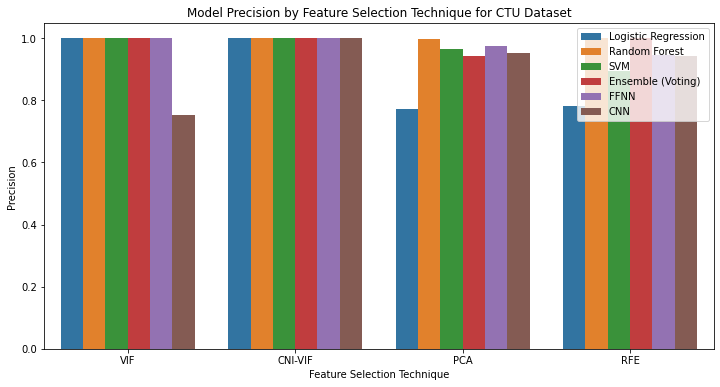

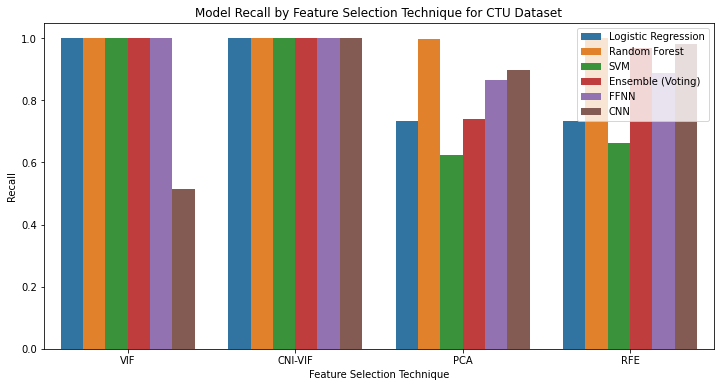

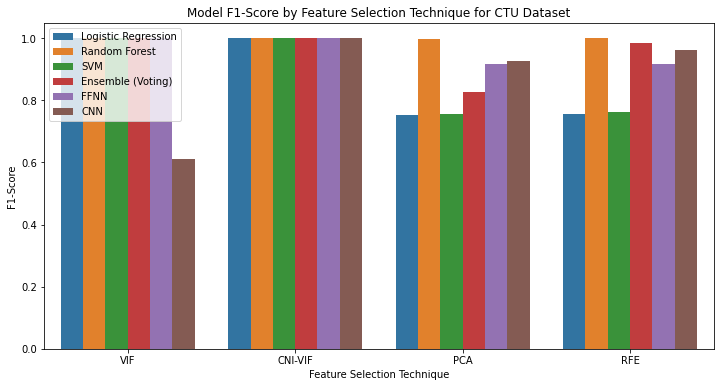

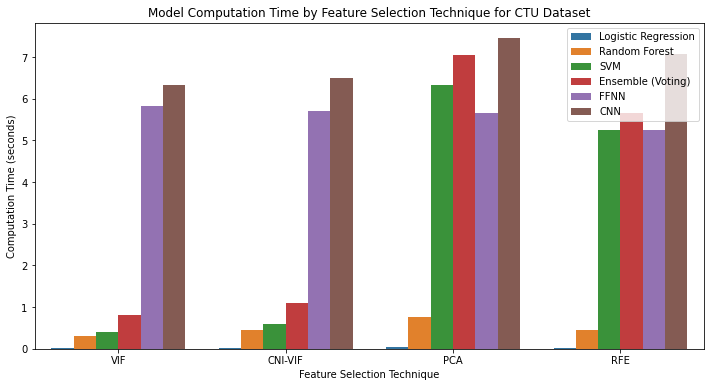

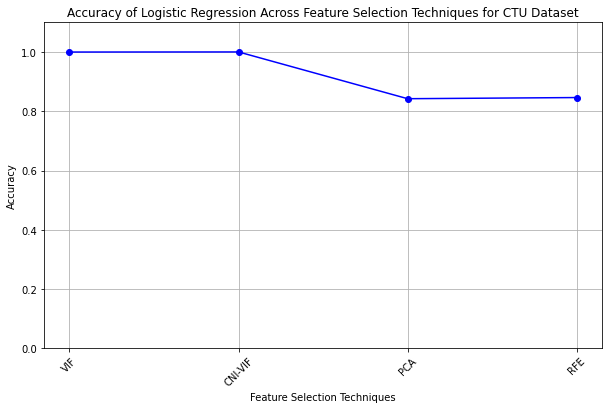

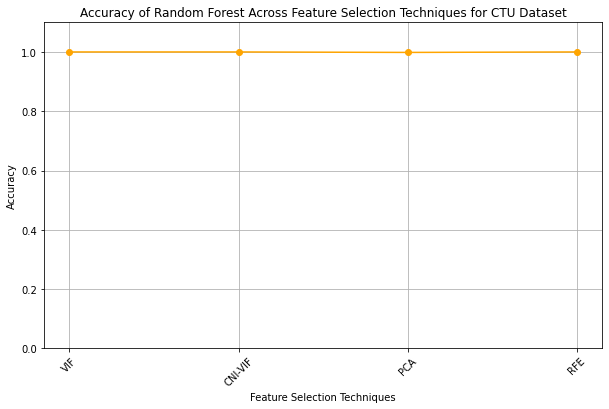

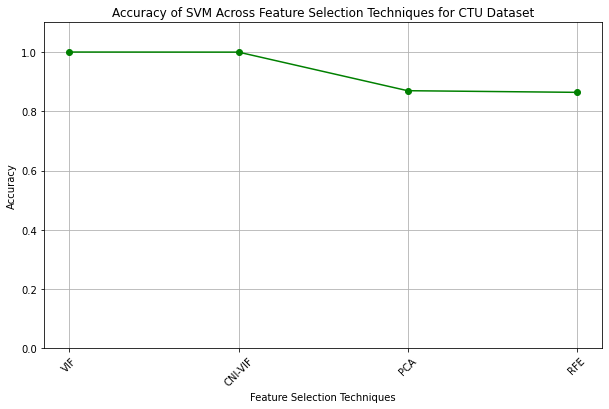

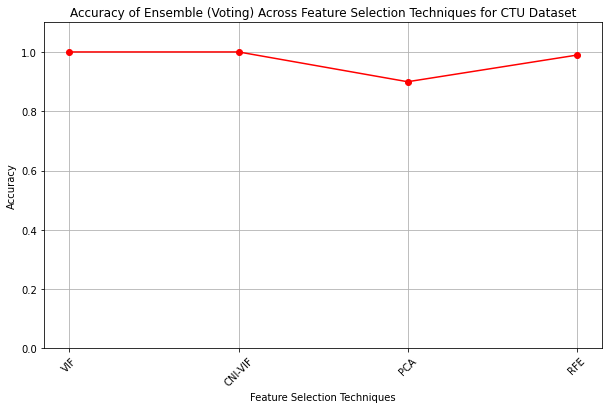

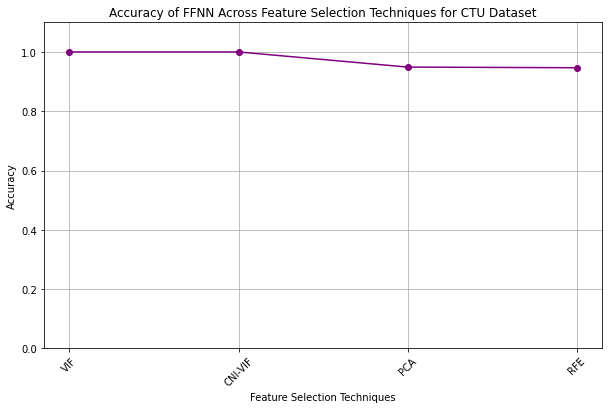

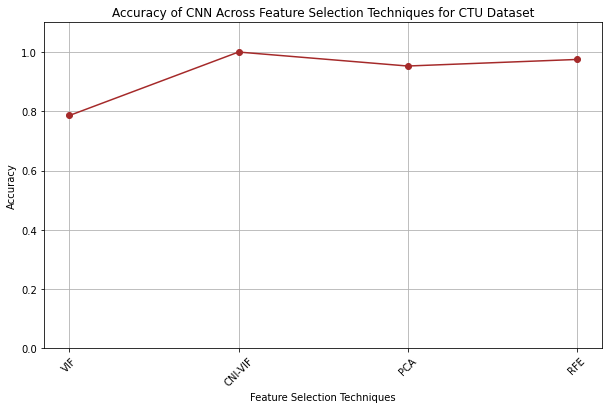

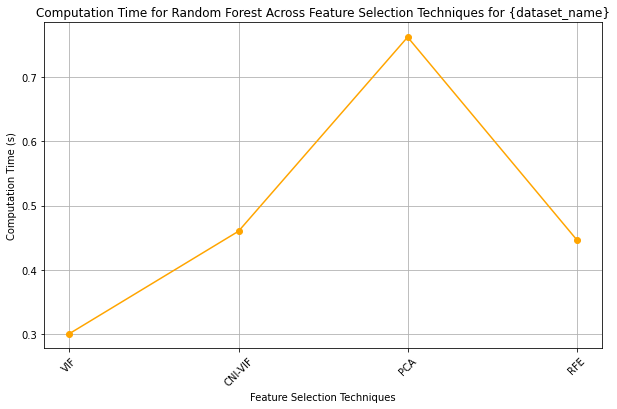

,Feature Selection Technique,Model,Accuracy,Precision,Recall,F1-Score,Computation Time
0,VIF,Logistic Regression,0.999675,0.999007,1.000000,0.999503,0.016986
1,VIF,Random Forest,1.000000,1.000000,1.000000,1.000000,0.301100
2,VIF,SVM,0.999675,1.000000,0.999006,0.999503,0.392410
3,VIF,Ensemble (Voting),1.000000,1.000000,1.000000,1.000000,0.813079
4,VIF,FFNN,1.000000,1.000000,1.000000,1.000000,5.812980
5,VIF,CNN,0.785691,0.751814,0.514911,0.611209,6.328727
6,CNI-VIF,Logistic Regression,1.000000,1.000000,1.000000,1.000000,0.018109
7,CNI-VIF,Random Forest,1.000000,1.000000,1.000000,1.000000,0.460084
8,CNI-VIF,SVM,0.999350,0.999006,0.999006,0.999006,0.592304
9,CNI-VIF,Ensemble (Voting),1.000000,1.000000,1.000000,1.000000,1.108747


In [26]:
table2 = final_output(df_ctu,"SrcAddr","DstAddr","CTU Dataset")
table2
